## fast-paced test solution

some code was borrowed from https://github.com/qubvel-org/segmentation_models.pytorch/blob/main/examples/camvid_segmentation_multiclass.ipynb 

solve semantic segmentation with hierarchy of the body. given three metrics on pascal part dataset

* mIoU<sup>0</sup> - `body`
* mIou<sup>1</sup> - `upper_body`, `lower_body`
* mIoU<sup>2</sup> - `low_hand`, `up_hand`, `torso`, `head`, `low_leg`, `up_leg`


One of the most straightforward solutions is to use multiple heads of pretrained model. Another one is to make a cascade of models and combine them into one torch Module. 

I tried both solutions and the second one is a no to me due to low RAM in my computer (6GBs) and constant heating issues with long training times

I will use first one then because it's more convenient for me to only modify segmentation head, thus having better training speed and I can only modify the last output layers

### dataset

In [1]:
import os
import numpy as np
from PIL import Image
from torchvision.io import decode_image

from torch.utils.data import Dataset, DataLoader
import torchvision.transforms.v2 as T

from torchvision import tv_tensors
import torch

class PascalDS(Dataset):
    """
    Pascal part dataset with on the fly mask creation
    """
    def __init__(self, file_list_path, transform=None):
        self.transform = transform

        with open(file_list_path, "r") as f:
            self.filenames = [line.strip() for line in f if line.strip()]

    def __len__(self):
        return len(self.filenames)

    def __getitem__(self, idx):
        """ 
        Create masks on the fly based on classes. Transform applies to all image and masks
        and filters what to use inside torchvision transforms class to prevent scaling integer masks
        """
        
        img_filename = self.filenames[idx]
        img_basename = img_filename.split("/")[-1]

        img_path = os.path.join(
            "/mnt/c/datasets/pascal_part/JPEGImages", img_filename + ".jpg"
        )
        mask_path = os.path.join(
            "/mnt/c/datasets/pascal_part/gt_masks", img_basename + ".npy"
        )

        image = decode_image(img_path)

        full_mask = np.load(mask_path)
        # consider any part of body as body or class 1
        binary_mask = (full_mask > 0).astype(np.uint8)

        upper = [4, 2, 1, 6]
        lower = [3, 5]
        triple_mask = np.zeros_like(full_mask, dtype=np.uint8)
        # upper body of triple is 1
        triple_mask[np.isin(full_mask, upper)] = 1
        # and lower is 2
        triple_mask[np.isin(full_mask, lower)] = 2


        if self.transform is not None:
            image, binary_mask, triple_mask, full_mask = self.transform(
                image, binary_mask, 
            triple_mask, full_mask
                )
            
            full_mask = full_mask.long()
            binary_mask = binary_mask.long()
            triple_mask = triple_mask.long()


        return image, binary_mask, triple_mask, full_mask

In [2]:
root_path = "/mnt/c/datasets/pascal_part"

images_dir = f"{root_path}/JPEGImages"
masks_dir = f"{root_path}/gt_masks"

# I don't use strong augmentations here because with multiple heads manual channel
# alignment in any kind of interpolation needed in order
# to properly use them and it's not my goal here
# simple augs are safe

train_tfs = T.Compose(
    [
        T.ToImage(),
        T.RandomResizedCrop((256, 256)),
        T.RandomAdjustSharpness(p=0.4, sharpness_factor=1),
        T.RandomAffine(degrees=25),
        T.GaussianBlur(kernel_size=5),
        T.RandomHorizontalFlip(p=1),
T.ToDtype(dtype={tv_tensors.Image: torch.float32, tv_tensors.Mask: torch.uint8, "others":
    torch.int64}, scale=False),

    ]
)

test_tfs = T.Compose([
    T.ToImage(),
    T.Resize((256, 256)),
    T.ToDtype(dtype={tv_tensors.Image: torch.float32, tv_tensors.Mask: torch.uint8, "others":
    torch.int64}, scale=False),
])

# Combine into a dataset
train_ds = PascalDS(
    file_list_path="/mnt/c/datasets/pascal_part/train_id.txt",
    transform=train_tfs)

test_ds = PascalDS(
    file_list_path="/mnt/c/datasets/pascal_part/val_id.txt",
    transform=test_tfs)

In [3]:
import matplotlib.pyplot as plt
from typing import Any


def print_mask(overwrite_exist: bool,
    image_path: Any, mask_path: Any, output_path: str, alpha: float = 0.5,
    mode: str = "full"
    
):
    """  
    function to visualize file image and masks
    """

    # explicit class mapping
    if mode == "full":
        label_names = {
            0: "bg",
            1: "low_hand",
            2: "torso",
            3: "low_leg",
            4: "head",
            5: "up_leg",
            6: "up_hand",
        }

        # explicit color selection
        label_colors = np.array(
            [
                [0, 0, 0],  # bg
                [255, 0, 0],  # low_hand R
                [0, 255, 0],  # torso G
                [0, 0, 255],  # low_leg B
                [255, 255, 0],  # head Y
                [255, 0, 255],  # up_leg P
                [0, 255, 255],  # up_hand Cyan
            ],
            dtype=np.uint8,
        )
    elif mode == "binary":
        label_names = {
            0: "bg",
            1: "body",
            }

            # explicit color selection
        label_colors = np.array(
                    [
                        [0, 0, 0],  # bg
                        [255, 255, 255], 
                    ],
                    dtype=np.uint8)
    else:
        label_names = {
            0: "bg",
            1: "upper",
            2: "lower",
        }

        # explicit color selection
        label_colors = np.array(
            [
                [0, 0, 0],  # bg
                [255, 0, 0],  # low_hand R
                [0, 255, 0],  # torso G
            ],
            dtype=np.uint8,
        )

    if not overwrite_exist:
        image = np.array(Image.open(image_path).convert("RGB"))

        mask = np.load(mask_path)
    else:
        image = image_path
        mask = mask_path
    
    color_mask = label_colors[mask]
    print(color_mask.shape)

    # blending factor to apply transparency
    blended = (1 - alpha) * image + alpha * color_mask
    blended = blended.astype(np.uint8)

    fig, ax = plt.subplots(figsize=(8, 6))
    ax.imshow(blended)
    ax.axis("off")

    unique_labels = np.unique(mask)
    for label_id in unique_labels:
        if label_id == 0:
            continue

        coords = np.argwhere(mask == label_id)
        if coords.size == 0:
            continue

        y_mean, x_mean = coords.mean(axis=0)

        label_text = label_names.get(label_id, f"Class {label_id}")

        ax.text(
            x_mean,
            y_mean,
            label_text,
            color="white",
            fontsize=12,
            ha="center",
            va="center",
            bbox=dict(boxstyle="round,pad=0.3", fc="black", alpha=0.5),
        )

    fig.savefig(output_path, bbox_inches="tight", pad_inches=0)
    plt.close(fig)

    print(f"Saved to: {output_path}")

In [4]:
img, full_mask = (
    "/mnt/c/datasets/pascal_part/JPEGImages/2008_000034.jpg",
    "/mnt/c/datasets/pascal_part/gt_masks/2008_000034.npy",
)

output_path = "/home/linda/mil_test/test.png"

print_mask(False, img, full_mask, output_path, 1)

(500, 338, 3)
Saved to: /home/linda/mil_test/test.png


### Model

I will use segformer from segmentation_models_pytorch (SMP further) as it's good in metrics and it can be modularly replaced with another model. It's code defined outside of this notebook in segformer.py

In [5]:
from segformer import Segformer

/home/linda/miniconda3/envs/vis/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


let's load and check our model. I will train in lightning so it's just an example of layers

In [6]:
model = Segformer(
    encoder_name="mit_b3",
    encoder_depth=5,
    encoder_weights="imagenet",
)

I will use fully decoupled lr from optimi package and stable adamw from there to ensure no losses go nan during bf16 training

In [8]:
epochs = 100
bs = 23
lr = 7e-5
eps = 1e-6
# for decoupled wd
w_reg = 1e-5

In [9]:
train_dl = DataLoader(train_ds, batch_size=bs, shuffle=True, num_workers=12)
test_dl = DataLoader(test_ds, batch_size=bs, shuffle=False, num_workers=12)


In [10]:
import segmentation_models_pytorch as smp

from torchmetrics.segmentation import MeanIoU

import torch.nn.functional as F

params = smp.encoders.get_preprocessing_params("mit_b3")

get encoder mean and std to normalize our image feeded into network according to pretraining parameters

In [11]:
params["mean"]

[0.485, 0.456, 0.406]

### Lightning code (actual)

In [12]:
!pip install torch-optimi

In [13]:
from optimi import StableAdamW

Now to interesting parts - we need multiple losses for our multihead beast as they are solving different tasks and gradient update should be done on them separately. 

My first draft was to use CrossEntropy with soft labels but the model didn't learn

Second attempt was Dice loss and the model started training but metrics were low, especially full mask iou, so I switched to Tversky loss to punish FP and FN

In [14]:
from segmentation_models_pytorch.losses import TverskyLoss
import pytorch_lightning as pl
import segmentation_models_pytorch as smp
import torch
from torch.optim import lr_scheduler

This is the main model code written in lightning

In [15]:
class PascalModel(pl.LightningModule):
    def __init__(self, encoder_name, **kwargs):
        super().__init__()
        
        # define base torch model inside init
        # the classes are hardcoded inside segformer.py 
        self.model = Segformer(
        encoder_name="mit_b3",
        encoder_depth=5,
        encoder_weights="imagenet",
        )

        # get preproc from imagenet encoder pretraining
        self.params = smp.encoders.get_preprocessing_params(encoder_name)
        
        # to tell model not to update this 
        self.register_buffer("std", torch.tensor(self.params["std"]).view(1, 3, 1, 1))
        self.register_buffer("mean", torch.tensor(self.params["mean"]).view(1, 3, 1, 1))

        # this is our losses, alpha and beta are same bc changing them between one another
        # can lead to overfit so it stays the same for three of them
        
        self.binary_loss_fn = TverskyLoss(mode="multiclass", smooth=0.05, classes=2, alpha=2, beta=1)
        self.triple_loss_fn = TverskyLoss(mode="multiclass", smooth=0.05, classes=3, alpha=2, beta=1)
        self.fine_loss_fn = TverskyLoss(mode="multiclass", smooth=0.05, classes=7, alpha=2, beta=1)
        
        # loss scaling factor. changind them can lead to poorer metrics
        # or overfit so let it be even weighting
        
        self.binary_lambda = 0.33
        self.tri_lambda = 0.33
        self.full_lambda = 0.33

        # calculate miou as torchmetrics class
        # we have bg class on output but it shouldn't exist inside our metric calculation
        self.miou_binary = MeanIoU(num_classes=2, input_format="index", include_background=False)
        self.miou_triple = MeanIoU(num_classes=3, input_format="index", include_background=False)
        self.miou_fine = MeanIoU(num_classes=7, input_format="index", include_background=False)


    def forward(self, img):
        # forward pass of model normalizes img internally
        img = T.Normalize(self.params["mean"], self.params["std"])(img)
        return self.model(img)

    def training_step(self, batch):
        """
        training step of model
        
        batch = (img, bin_mask, tr_mask, full_mask)
        """
        img, bin_mask, tr_mask, full_mask = batch

        bin_pred, tr_pred, full_pred = self(img)
        
        # ensure masks don't have single dim in masks channel
        bin_mask = bin_mask.squeeze(1).long()
        tr_mask = tr_mask.squeeze(1).long()
        full_mask = full_mask.squeeze(1).long()

        # weighted losses
        loss_bin = self.binary_lambda * self.binary_loss_fn(bin_pred, bin_mask)
        loss_tri = self.tri_lambda * self.triple_loss_fn(tr_pred, tr_mask)
        loss_full = self.full_lambda * self.fine_loss_fn(full_pred, full_mask)

        total_loss = loss_bin + loss_tri + loss_full

        self.log("train_loss", total_loss, prog_bar=True)

        return total_loss

    def validation_step(self, batch):
        """
        validation step for logging val loss and IoU metrics
        """
        img, bin_mask, tr_mask, full_mask = batch
        
        bin_pred, tr_pred, full_pred = self(img)

        bin_mask = bin_mask.squeeze(1).long()
        tr_mask = tr_mask.squeeze(1).long()
        full_mask = full_mask.squeeze(1).long()

        loss_bin = self.binary_lambda * self.binary_loss_fn(bin_pred, bin_mask)
        loss_tri = self.tri_lambda * self.triple_loss_fn(tr_pred, tr_mask)
        loss_full = self.full_lambda * self.fine_loss_fn(full_pred, full_mask)
        
        val_loss = loss_bin + loss_tri + loss_full

        self.log("val_loss", val_loss, prog_bar=True, on_epoch=True)

        # create preds
        # shapes: B C H W where C num classes
        bin_pred = bin_pred.softmax(dim=1).argmax(dim=1)
        tr_pred = tr_pred.softmax(dim=1).argmax(dim=1)
        full_pred = full_pred.softmax(dim=1).argmax(dim=1)

        # update iou metrics
        self.miou_binary.update(bin_pred, bin_mask)
        self.miou_triple.update(tr_pred, tr_mask)
        self.miou_fine.update(full_pred, full_mask)

        return val_loss

    def on_validation_epoch_end(self):
        """
        aggregate iou metrics over the entire validation set
        """
        bin_iou = self.miou_binary.compute()
        tri_iou = self.miou_triple.compute()
        fine_iou = self.miou_fine.compute()

        self.log("val_bin_iou", bin_iou, prog_bar=True)
        self.log("val_trip_iou", tri_iou, prog_bar=True)
        self.log("val_full_iou", fine_iou, prog_bar=True)

        # Reset metrics to start fresh next epoch
        self.miou_binary.reset()
        self.miou_triple.reset()
        self.miou_fine.reset()

    def predict_step(self, batch):
        """  
        Pred step for inference
        """

        img, _, _, _ = batch
        
        # forward pass
        bin_pred, tr_pred, full_pred = self(img)

        # get predictions
        bin_pred_cls = bin_pred.softmax(dim=1).argmax(dim=1)
        tr_pred_cls  = tr_pred.softmax(dim=1).argmax(dim=1)
        full_pred_cls= full_pred.softmax(dim=1).argmax(dim=1)

        return {
            "bin_pred": bin_pred_cls,
            "tr_pred": tr_pred_cls,
            "full_pred": full_pred_cls
        }

    def configure_optimizers(self):
        optimizer = StableAdamW(self.parameters(), lr=lr, weight_decay=w_reg, 
                                decouple_lr=True,
                                kahan_sum=True)
        scheduler = lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=25)
        return {
            "optimizer": optimizer,
            "lr_scheduler": {
                "scheduler": scheduler,
                "interval": "step",
                "frequency": 1,
            },
        }

In [16]:
model = PascalModel("mit_b3", 
                    encoder_depth=5)

get useful callbacks

In [17]:
from pytorch_lightning.callbacks import StochasticWeightAveraging, EarlyStopping, ModelCheckpoint

early stop if metrics decrease

In [18]:
early_stopping = EarlyStopping('val_full_iou', mode="max", patience=6)

model_chck = ModelCheckpoint(monitor='val_full_iou', save_top_k=2,  mode="max")

log to tensorboard

In [19]:
from pytorch_lightning.loggers import TensorBoardLogger

logger = TensorBoardLogger("/home/linda/mil_test/checkpoints_2")


finally we can train!

In [21]:
trainer = pl.Trainer(max_epochs=epochs,
                     # train in bf16
                     precision="bf16", accelerator="gpu", check_val_every_n_epoch=3,
                     # clip grad norm for stability
                     # uncomment if stableadamw
                     # gradient_clip_val=0.3,
                     callbacks=[model_chck,
                                early_stopping],
                     # make gradient accumulation for larger BS with increase time
                     default_root_dir="/home/linda/mil_test/checkpoints_2",
                     logger=logger)

trainer.fit(
    model,
    train_dataloaders=train_dl,
    val_dataloaders=test_dl,
    # resume training
    # ckpt_path="/home/linda/mil_test/checkpoints_2/lightning_logs/version_12/checkpoints/epoch=26-step=1593.ckpt"
)

Using bfloat16 Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 3060 Laptop GPU') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type        | Params | Mode 
-------------------------------------------------------
0 | model          | Segformer   | 44.6 M | train
1 | binary_loss_fn | TverskyLoss | 0      | train
2 | triple_loss_fn | TverskyLoss | 0      | train
3 | fine_loss_fn   | TverskyLoss | 0      | train
4 | miou_binary    | MeanIoU     | 0      | train
5 | miou_triple    | MeanIoU     | 0      | train
6 | miou_fine

Epoch 99: 100%|██████████| 123/123 [00:47<00:00,  2.60it/s, v_num=22, train_loss=0.208, val_loss=0.297, val_bin_iou=0.701, val_trip_iou=0.498, val_full_iou=0.342]

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 123/123 [00:47<00:00,  2.60it/s, v_num=22, train_loss=0.208, val_loss=0.297, val_bin_iou=0.701, val_trip_iou=0.498, val_full_iou=0.342]


now after training we can finally predict our model on same set

### inference

now let's predict and look at our masks closely

In [20]:
model = PascalModel.load_from_checkpoint("/home/linda/mil_test/checkpoints_2/lightning_logs/version_22/checkpoints/epoch=98-step=12177.ckpt",
                                         hparams_file="/home/linda/mil_test/checkpoints_2/lightning_logs/version_22/hparams.yaml",
                                         encoder_name="mit_b3")

In [40]:
%%capture
model.to("cuda")
model.eval()


In [23]:
for i, batch in enumerate(test_dl):
    img, _, _, _ = batch
    bin_pred, tr_pred, full_pred = model(img.to("cuda"))
    
    bin_pred = bin_pred.softmax(dim=1).argmax(dim=1)
    tr_pred = tr_pred.softmax(dim=1).argmax(dim=1)
    full_pred = full_pred.softmax(dim=1).argmax(dim=1)
    break

In [31]:
bin_msk, tr_msk, f_msk = bin_pred[-1], tr_pred[-1], full_pred[-1]

In [37]:
img_pred = img[-1].cpu().detach().numpy().long()

In [38]:
bin_msk = bin_msk.cpu().detach().numpy().long()
tr_msk = tr_msk.cpu().detach().numpy().long()
f_msk = f_msk.cpu().detach().numpy().long()

In [80]:
print_mask(True, np.moveaxis(img_pred.astype(np.uint8), 0, -1), bin_msk.astype(np.uint8), "/home/linda/mil_test/bin.png",
           mode="binary", alpha=1)

(256, 256, 3)
Saved to: /home/linda/mil_test/bin.png


In [83]:
print_mask(True, np.moveaxis(img_pred.astype(np.uint8), 0, -1), tr_msk.astype(np.uint8), 
           "/home/linda/mil_test/triple.png",
           mode="triple", alpha=0.5)

(256, 256, 3)
Saved to: /home/linda/mil_test/triple.png


In [84]:
print_mask(True, np.moveaxis(img_pred.astype(np.uint8), 0, -1), f_msk.astype(np.uint8),
           "/home/linda/mil_test/full.png",
           mode="full", alpha=0.5)

(256, 256, 3)
Saved to: /home/linda/mil_test/full.png


### out of the dataset predict

now let's use some real world examples not from datasets. photo of Hideo Kojima for example

In [26]:
sample_img = np.array(Image.open("/mnt/c/Users/Adult/Downloads/hideo-kojima-sam-lake-1_jpg_1600x900_crop_q85.jpg").convert("RGB"))

In [27]:
sample_img = test_tfs(sample_img)

In [28]:
bin_pred, tr_pred, full_pred = model(sample_img.unsqueeze(0).to("cuda"))

bin_pred = bin_pred.softmax(dim=1).argmax(dim=1)
tr_pred = tr_pred.softmax(dim=1).argmax(dim=1)
full_pred = full_pred.softmax(dim=1).argmax(dim=1)


In [33]:
bin_msk = bin_msk.cpu().detach().numpy()
tr_msk = tr_msk.cpu().detach().numpy()
f_msk = f_msk.cpu().detach().numpy()

In [35]:
sample_img = sample_img.cpu().detach().numpy()

In [36]:
print_mask(True, np.moveaxis(sample_img.astype(np.uint8), 0, -1), bin_msk.astype(np.uint8),
           "/home/linda/mil_test/bin_hideo.png",
           mode="binary", alpha=1)

(256, 256, 3)
Saved to: /home/linda/mil_test/bin_hideo.png


In [37]:
print_mask(True, np.moveaxis(sample_img.astype(np.uint8), 0, -1), tr_msk.astype(np.uint8),
           "/home/linda/mil_test/tr_hideo.png",
           mode="triple", alpha=0.5)

(256, 256, 3)
Saved to: /home/linda/mil_test/tr_hideo.png


In [38]:
print_mask(True, np.moveaxis(sample_img.astype(np.uint8), 0, -1), f_msk.astype(np.uint8),
           "/home/linda/mil_test/full_hideo.png",
           mode="full", alpha=0.5)

(256, 256, 3)
Saved to: /home/linda/mil_test/full_hideo.png


our model can indeed segment any person with decent test set metrics!

### summary

I can conclude, that using multihead segmentation model works quite good with few resources that I have. We managed to fit segformer into consumer-grade notebook gpu, train in bf16 and get predictions.
Final metrics are
- binary miou - 0.701
- triple iou - 0.498
- full iou - =0.342

They are not even close to SotA on this dataset
There is a way forward to squeeze more from the model, such as training in higher BS, using larger encoder, TTAs, cutmix, mixup, training more, tuning parameters, augmenting images further. Some ideas beyond current setup are:

1. Using another loss, more rewarding model on finding exact parts of body and using hierarchial structure of labels to reward leaves of the hierarchial tree. Something like https://github.com/lingorX/HieraSeg/tree/cc3c1cfbabe3cc2af620e0193a245822cca8a841/Pytorch
2. Using another model, more complex layer building. Maybe MMSeg package models can make better metrics
3. More GPUs, DDP, FSDP, DeepSpeed
4. Use SAM model for zero shot more mask creation or even fine tune one instead of traditional methods
5. Use 4k image upscale in test time and different image ratios in training

### tensorboard plots 

additional tensorboard plots of metrics to demonstrate my training run

### IOUs:

##### binary
- 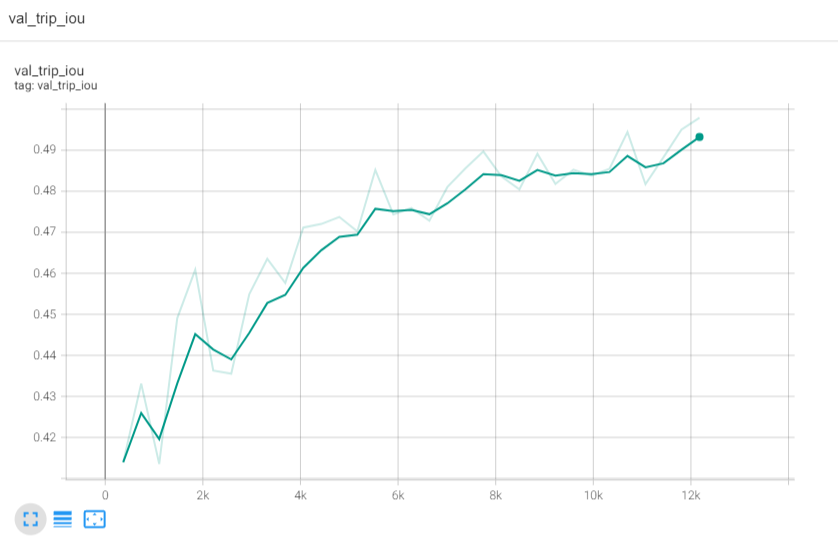
##### triple
- 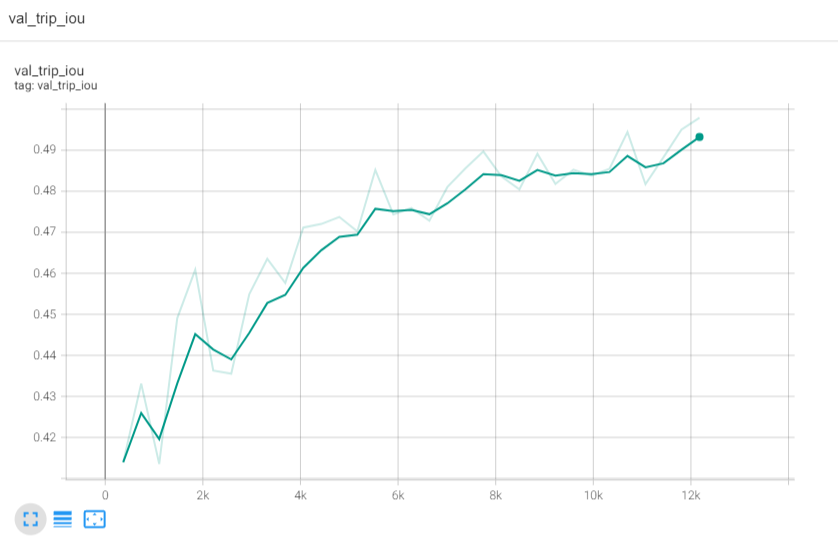
##### full
- 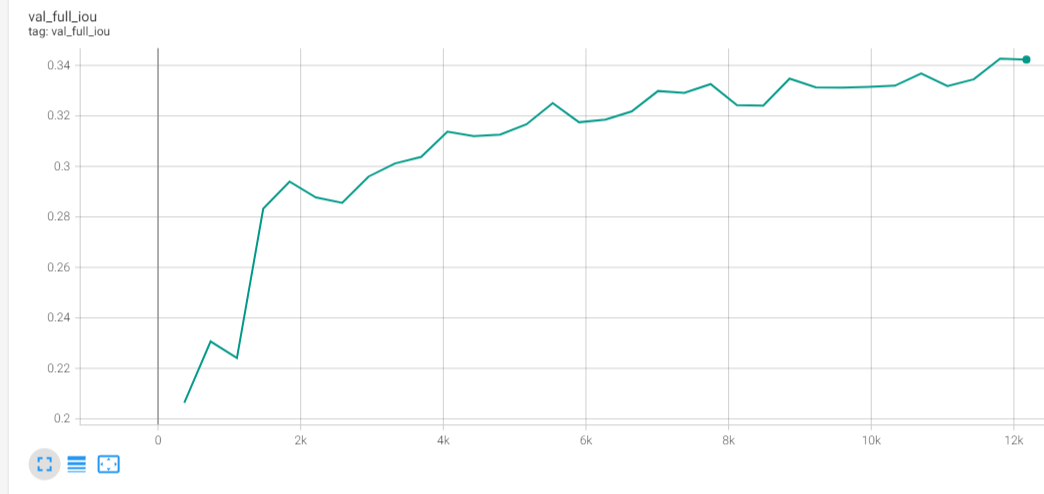

### losses

##### train loss
- 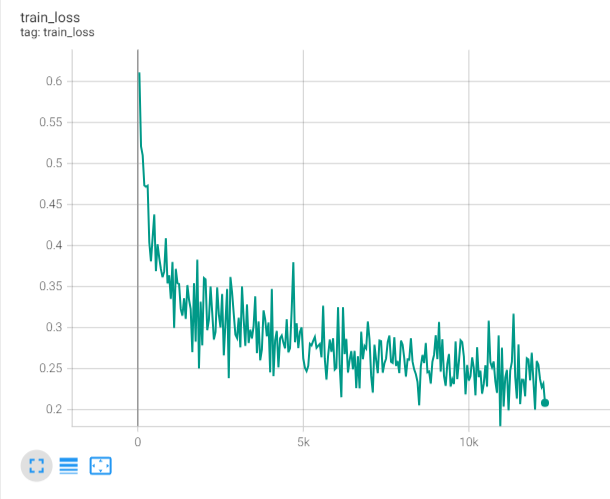
##### val loss
- 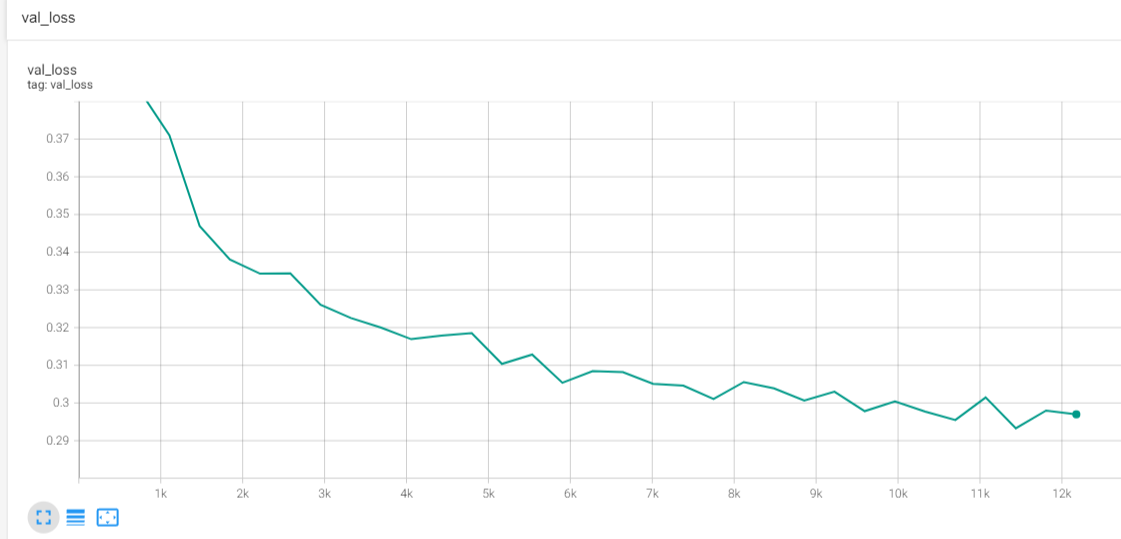


we can see that the model haven't overfitted yet and there's an still an opportunity to grow further